In [11]:
!pip install transformers torch pandas scikit-learn ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=734eae9b1cea5285c322ce3cc748cd83751e60723cd8c5b2bd3c4a14daf320c1
  Stored in directory: c:\users\mehur\appdata\local\pip\cache\wheels\a1\d7\29\7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [12]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import sys
import ta


In [13]:
# Updated Configuration Parameters
config = {
    'stock': '^GSPC',
    'start_date': '1980-01-01',
    'end_date': '2024-08-10',
    'forecast_horizon': 16,
    'seq_length': 64,
    'batch_size': 16,  # Updated to the best-performing batch size
    'model_dim': 1024,  # Updated to the best-performing model dimension
    'num_heads': 4,  # Updated to the best-performing number of heads
    'num_layers': 1,  # Updated to the best-performing number of layers
    'dropout': 0.302336647888835,  # Updated to the best-performing dropout rate
    'learning_rate': 0.00019167217058609182,  # Updated to the best-performing learning rate
    'num_epochs': 64,  # Keeping this consistent unless specific insights suggest otherwise
    'early_stopping_patience': 20,  # Keeping this consistent unless specific insights suggest otherwise
    'window_size': 10,  # Keeping this consistent unless specific insights suggest otherwise
    'subset_start_date': '2024-06-01',  # Keeping this consistent unless specific insights suggest otherwise
    'subset_end_date': '2024-08-10',  # Keeping this consistent unless specific insights suggest otherwise
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'max_len': 64,  # Should match seq_length
    'scaling_method': 'standard',  # Keeping this consistent unless specific insights suggest otherwise
    'weight_decay': 6.185062729292181e-06,  # Updated to the best-performing weight decay
    'optimizer': 'Adam',  # Updated to the best-performing optimizer
    'scheduler': 'CosineAnnealingLR',  # Updated to the best-performing scheduler
    'T_max': 31,  # Updated to the best-performing T_max for CosineAnnealingLR
    'eta_min': 5.116919592728347e-06,  # Updated to the best-performing eta_min for CosineAnnealingLR
}


In [44]:
def download_and_preprocess_data(stock, start, end):
    """
    Downloads stock data and extracts various technical indicators.

    Args:
        stock (str): Stock ticker symbol.
        start (str): Start date in 'YYYY-MM-DD'.
        end (str): End date in 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: Dataframe containing technical indicators.
    """
    try:
        yfd = yf.download(stock, start=start, end=end)
    except Exception as e:
        print(f"Error downloading data: {e}")
        sys.exit(1)

    # Drop rows with missing values
    yfd.dropna(inplace=True)
    
    # Calculate percentage change in closing prices
    yfd['Pct_Change'] = yfd['Close'].pct_change() * 100
    
    # Moving Averages
    yfd['SMA_20'] = yfd['Close'].rolling(window=20).mean()
    yfd['SMA_50'] = yfd['Close'].rolling(window=50).mean()
    yfd['EMA_20'] = yfd['Close'].ewm(span=20, adjust=False).mean()
    
    # RSI
    yfd['RSI'] = ta.momentum.RSIIndicator(yfd['Close'], window=14).rsi()
    
    # MACD
    macd = ta.trend.MACD(yfd['Close'])
    yfd['MACD'] = macd.macd()
    yfd['MACD_Signal'] = macd.macd_signal()
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(yfd['Close'], window=20)
    yfd['BB_High'] = bollinger.bollinger_hband()
    yfd['BB_Low'] = bollinger.bollinger_lband()
    
    # Volume-based indicators
    yfd['OBV'] = ta.volume.OnBalanceVolumeIndicator(yfd['Close'], yfd['Volume']).on_balance_volume()

    # Additional Indicators
    # Stochastic Oscillator
    yfd['Stoch'] = ta.momentum.StochasticOscillator(yfd['High'], yfd['Low'], yfd['Close']).stoch()
    
    # Average True Range (ATR)
    yfd['ATR'] = ta.volatility.AverageTrueRange(yfd['High'], yfd['Low'], yfd['Close']).average_true_range()
    
    # Williams %R
    yfd['Williams_%R'] = ta.momentum.WilliamsRIndicator(yfd['High'], yfd['Low'], yfd['Close']).williams_r()
    
    # Commodity Channel Index (CCI)
    yfd['CCI'] = ta.trend.CCIIndicator(yfd['High'], yfd['Low'], yfd['Close'], window=20).cci()
    
    # Rate of Change (ROC)
    yfd['ROC'] = ta.momentum.ROCIndicator(yfd['Close']).roc()
    
    # Average Directional Index (ADX)
    yfd['ADX'] = ta.trend.ADXIndicator(yfd['High'], yfd['Low'], yfd['Close']).adx()
    
    # Accumulation/Distribution Index (ADI)
    yfd['ADI'] = ta.volume.AccDistIndexIndicator(yfd['High'], yfd['Low'], yfd['Close'], yfd['Volume']).acc_dist_index()
    
    # Drop any rows with NaN values after adding indicators
    yfd.dropna(inplace=True)
    
    return yfd

df = download_and_preprocess_data(config['stock'], config['start_date'], config['end_date'])
df.head()

# Standardize the features
features = df[['Pct_Change', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 
               'BB_High', 'BB_Low', 'OBV', 'Stoch', 'ATR', 'Williams_%R', 'CCI', 
               'ROC', 'ADX', 'ADI']].values
"""
scaler = StandardScaler()
features = scaler.fit_transform(features)
"""

def convert_to_text(df):
    text_data = []
    
    for _, row in df.iterrows():
        text = (
            f"date: {row.name.date()}, "
            f"price_change: {row['Pct_Change']:.2f}, "
            f"sma_20: {row['SMA_20']:.2f}, "
            f"sma_50: {row['SMA_50']:.2f}, "
            f"ema_20: {row['EMA_20']:.2f}, "
            f"rsi: {row['RSI']:.2f}, "
            f"macd: {row['MACD']:.2f}, "
            f"macd_signal: {row['MACD_Signal']:.2f}, "
            f"bb_high: {row['BB_High']:.2f}, "
            f"bb_low: {row['BB_Low']:.2f}, "
            f"obv: {row['OBV']:.2f}, "
            f"stoch: {row['Stoch']:.2f}, "
            f"atr: {row['ATR']:.2f}, "
            f"williams_r: {row['Williams_%R']:.2f}, "
            f"cci: {row['CCI']:.2f}, "
            f"roc: {row['ROC']:.2f}, "
            f"adx: {row['ADX']:.2f}, "
            f"adi: {row['ADI']:.2f}"
        )
        text_data.append(text)
    
    return text_data

# Convert the dataframe to text format
text_data = convert_to_text(df)

# Display the first few converted text data points
for i, text in enumerate(text_data[:5]):
    print(f"Text {i+1}: {text}")
    

from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
encoded_data = tokenizer(text_data, padding=True, truncation=True, return_tensors="pt")

# Prepare tensors for labels
labels = torch.tensor(df['Pct_Change'].values, dtype=torch.float32)

# Assuming you already have `text_data` and `labels` as tensors

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(encoded_data['input_ids'], labels, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)



[*********************100%%**********************]  1 of 1 completed


Text 1: date: 1980-03-12, price_change: -0.84, sma_20: 112.54, sma_50: 112.38, ema_20: 111.20, rsi: 32.63, macd: -1.69, macd_signal: -0.78, bb_high: 119.44, bb_low: 105.64, obv: 219160000.00, stoch: 16.90, atr: 2.77, williams_r: -83.10, cci: -140.94, roc: -5.70, adx: 26.59, adi: -38718016.04
Text 2: date: 1980-03-13, price_change: -1.17, sma_20: 111.90, sma_50: 112.38, ema_20: 110.66, rsi: 29.92, macd: -1.91, macd_signal: -1.01, bb_high: 118.87, bb_low: 104.93, obv: 186090000.00, stoch: 6.86, atr: 2.75, williams_r: -93.14, cci: -137.11, roc: -7.33, adx: 27.30, adi: -57750049.38
Text 3: date: 1980-03-14, price_change: -0.18, sma_20: 111.33, sma_50: 112.38, ema_20: 110.17, rsi: 29.51, macd: -2.07, macd_signal: -1.22, bb_high: 118.48, bb_low: 104.19, obv: 150910000.00, stoch: 12.78, atr: 2.73, williams_r: -87.22, cci: -130.56, roc: -6.18, adx: 28.34, adi: -52643257.73
Text 4: date: 1980-03-17, price_change: -3.01, sma_20: 110.68, sma_50: 112.30, ema_20: 109.41, rsi: 23.77, macd: -2.43, ma

C:\Users\mehur\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [45]:
# Define model
class FinancialBERT(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(FinancialBERT, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        cls_token_output = outputs.last_hidden_state[:, 0, :]
        prediction = self.regressor(cls_token_output)
        return prediction

# Initialize model, optimizer, and loss function
model = FinancialBERT()
model.to(config['device'])

FinancialBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [46]:
optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
loss_fn = nn.MSELoss()

C:\Users\mehur\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [47]:
# Training loop
num_epochs = config['num_epochs']
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(config['device']), labels.to(config['device'])

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    # (Optional) Add validation here if needed

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1, Loss: 4.228709697723389
Epoch 2, Loss: 0.8957012891769409
Epoch 3, Loss: 2.156647205352783
Epoch 4, Loss: 0.1444012075662613
Epoch 5, Loss: 1.7842411994934082
Epoch 6, Loss: 0.9196561574935913
Epoch 7, Loss: 0.8277803063392639
Epoch 8, Loss: 0.6515084505081177
Epoch 9, Loss: 1.2830681800842285
Epoch 10, Loss: 0.6896889805793762
Epoch 11, Loss: 2.9064176082611084
Epoch 12, Loss: 2.6646440029144287
Epoch 13, Loss: 1.009215235710144
Epoch 14, Loss: 0.6967839002609253
Epoch 15, Loss: 0.8704098463058472
Epoch 16, Loss: 1.7616057395935059
Epoch 17, Loss: 0.7601248621940613
Epoch 18, Loss: 0.5265000462532043
Epoch 19, Loss: 1.2333875894546509
Epoch 20, Loss: 0.4164745509624481


KeyboardInterrupt: 

Mean Squared Error on the validation set: 1.2157789468765259


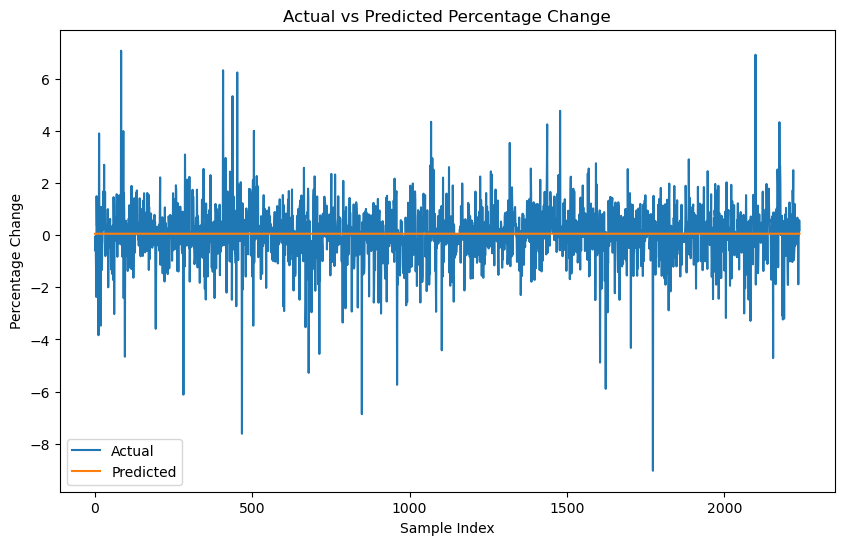

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Switch the model to evaluation mode
model.eval()

# Lists to store actual and predicted values
actuals = []
predictions = []

# Evaluate the model on the validation set
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        outputs = model(inputs)
        
        # Store the actual and predicted values
        actuals.extend(labels.numpy())
        predictions.extend(outputs.squeeze(-1).numpy())

# Calculate the MSE
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error on the validation set: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Percentage Change')
plt.xlabel('Sample Index')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()
